In [1]:
import pickle
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Carregar dados
with open('df_pedidos_baixados_2020_a_2023_processado.pkl', 'rb') as file:
    dados = pickle.load(file)
dados = dados[dados.Ano==2022]

In [4]:
dados.shape

(68177, 8)

In [5]:
percentual_de_recorte = 75  # Ajustar aqui para recortar
recorte_amostral = dados.query(f'PercentualAcumulado_2020_2023 <= {percentual_de_recorte}').copy()
print(recorte_amostral.OrgaoDestinatario.unique().shape)

percentual_limite = 70 # Ajustar aqui para definir os "Outros" (percentual_de_recorte-percentual_limite)
recorte_amostral['Orgao_alvo'] = recorte_amostral.apply(lambda row: row['OrgaoDestinatario'] 
                               if row['PercentualAcumulado_2020_2023'] <= percentual_limite else 'Outros', axis=1)
recorte_amostral = recorte_amostral[['Orgao_alvo', 'Mês', 'Dia da Semana', 'DetalhamentoSolicitacao']]
print(recorte_amostral.shape)
print(recorte_amostral.Orgao_alvo.unique().shape)

(61,)
(52178, 4)
(47,)


In [6]:
max_features_tfidf=29000

In [7]:
# Vetorização TF-IDF
vectorizer = TfidfVectorizer(max_features=max_features_tfidf) #maximo 29150 com 8gb
X_tfidf = vectorizer.fit_transform(recorte_amostral['DetalhamentoSolicitacao'])

# Codificação dos rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(recorte_amostral['Orgao_alvo'])
y_encoded = torch.tensor(y_encoded, dtype=torch.long)
y_encoded = nn.functional.one_hot(y_encoded)  # Convertendo para one-hot encoding

# Codificação dos parâmetros adicionais: mês e dia da semana
onehot_encoder = OneHotEncoder()
mes_dia_semana_encoded = onehot_encoder.fit_transform(recorte_amostral[['Mês', 'Dia da Semana']])

In [8]:
# Definindo conjunto de dados personalizado para PyTorch
class CustomDataset(Dataset):
    def __init__(self, X_tfidf, mes_dia_semana, y):
        self.X_tfidf = X_tfidf.to(device)
        self.mes_dia_semana = mes_dia_semana.to(device)
        self.y = y

    def __len__(self):
        return len(self.X_tfidf)

    def __getitem__(self, idx):
        return self.X_tfidf[idx], self.mes_dia_semana[idx], self.y[idx]

In [9]:
torch.cuda.empty_cache()

# Divisão em conjunto de treinamento e teste
X_train_tfidf, X_test_tfidf, y_train, y_test, mes_dia_semana_train, mes_dia_semana_test = train_test_split(
    X_tfidf, y_encoded, mes_dia_semana_encoded, test_size=0.2, random_state=42)

# Convertendo os dados para tensores densos
X_train_tfidf_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32).to(device) ####
X_test_tfidf_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32).to(device) ####
mes_dia_semana_train_tensor = torch.tensor(mes_dia_semana_train.toarray(), dtype=torch.float32).to(device) ####
mes_dia_semana_test_tensor = torch.tensor(mes_dia_semana_test.toarray(), dtype=torch.float32).to(device) ####
y_train_tensor = y_train.to(device) ####
y_test_tensor = y_test.to(device) ####

# Criando DataLoader para conjuntos de treinamento e teste
train_dataset = CustomDataset(X_train_tfidf_tensor, mes_dia_semana_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=90, shuffle=True)
test_dataset = CustomDataset(X_test_tfidf_tensor, mes_dia_semana_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=90, shuffle=False)

In [10]:
# Definindo o modelo de rede neural
class NeuralNetwork(nn.Module):
    def __init__(self, input_tfidf_shape, input_mes_dia_semana_shape, output_shape):
        super(NeuralNetwork, self).__init__()
        tamanho_entrada = input_tfidf_shape + input_mes_dia_semana_shape
        torch.manual_seed(42)
        self.fc1 = nn.Linear(tamanho_entrada, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, output_shape)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.05)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x_tfidf, x_mes_dia_semana):
        # Concatenando as duas entradas
        x = torch.cat((x_tfidf, x_mes_dia_semana), dim=1)
        # Passando pela primeira camada totalmente conectada
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc5(x)
        return self.logsoftmax(x)

In [11]:
# Inicializando o modelo
input_tfidf_shape = X_train_tfidf.shape[1]
input_mes_dia_semana_shape = mes_dia_semana_train.shape[1]
output_shape = y_encoded.shape[1]
model = NeuralNetwork(input_tfidf_shape, input_mes_dia_semana_shape, output_shape).to(device) ####
# Definindo a função de perda e otimizador
criterion = nn.CrossEntropyLoss().to(device) ####
optimizer1 = optim.Adam(model.parameters(), lr=0.01)
optimizer2 = optim.Adam(model.parameters(), lr=0.005)
optimizer3 = optim.Adam(model.parameters(), lr=0.001)
optimizer4 = optim.Adam(model.parameters(), lr=0.0005)

In [12]:
# Função para avaliação do modelo
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in test_loader:
            inputs_tfidf, inputs_mes_dia_semana, labels = data
            outputs = model(inputs_tfidf.float(), inputs_mes_dia_semana.float())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == torch.max(labels, 1)[1]).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(torch.max(labels, 1)[1].cpu().numpy())
    accuracy = correct / total
    return accuracy, y_true, y_pred
    
# Função para treinamento do modelo
def train(model, train_loader, test_loader, criterion, optimizer, epochs=10, use_best_model=False, early_stop=False):
    score=0
    if use_best_model:
        best_score = 0.01
        best_epoch = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs_tfidf, inputs_mes_dia_semana, labels = data
            optimizer.zero_grad()
            outputs = model(inputs_tfidf, inputs_mes_dia_semana)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if use_best_model or early_stop:
            accuracy, y_true, y_pred = evaluate_model(model, test_loader)
            precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
            recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
            score_anterior = score
            score = f1
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}", 
                  f"Acc: {accuracy:,.5f}", 
                  f"Prc: {precision:,.5f}", 
                  f"Rcl: {recall:,.5f}", 
                  f"F1: {f1:,.5f}")
            #print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}, Score: {score:,.5f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}")
        if use_best_model:
            if score > best_score:
                best_epoch = epoch+1
                best_score = score
                best_model_wts = copy.deepcopy(model.state_dict())
        if early_stop and score <= score_anterior:
            print(f"Métrica parou de melhorar. Interrompendo o treinamento...")
            break
    if use_best_model and best_epoch!=epoch+1:
        model.load_state_dict(best_model_wts)
        print(f"Carregando modelo da melhor epoca - {best_epoch}")
    print(f"Fim.")

In [13]:
# Treinamento do modelo
train(model, train_loader, test_loader, criterion, optimizer1, epochs=10, use_best_model=True, early_stop=True)
train(model, train_loader, test_loader, criterion, optimizer2, epochs=10, use_best_model=True, early_stop=True)
train(model, train_loader, test_loader, criterion, optimizer3, epochs=10, use_best_model=True, early_stop=True)
train(model, train_loader, test_loader, criterion, optimizer4, epochs=10, use_best_model=True, early_stop=True)

Epoch 1/10, Loss: 2.14347 Acc: 0.59889 Prc: 0.61865 Rcl: 0.59889 F1: 0.58354
Epoch 2/10, Loss: 1.15024 Acc: 0.64613 Prc: 0.65634 Rcl: 0.64613 F1: 0.64020
Epoch 3/10, Loss: 0.73313 Acc: 0.64824 Prc: 0.66765 Rcl: 0.64824 F1: 0.64907
Epoch 4/10, Loss: 0.55966 Acc: 0.66060 Prc: 0.68084 Rcl: 0.66060 F1: 0.66206
Epoch 5/10, Loss: 0.46696 Acc: 0.64565 Prc: 0.66131 Rcl: 0.64565 F1: 0.64662
Métrica parou de melhorar. Interrompendo o treinamento...
Carregando modelo da melhor epoca - 4
Fim.
Epoch 1/10, Loss: 0.44563 Acc: 0.67583 Prc: 0.69408 Rcl: 0.67583 F1: 0.67734
Epoch 2/10, Loss: 0.29150 Acc: 0.66884 Prc: 0.69800 Rcl: 0.66884 F1: 0.67417
Métrica parou de melhorar. Interrompendo o treinamento...
Carregando modelo da melhor epoca - 1
Fim.
Epoch 1/10, Loss: 0.28755 Acc: 0.68532 Prc: 0.70419 Rcl: 0.68532 F1: 0.68957
Epoch 2/10, Loss: 0.20176 Acc: 0.68599 Prc: 0.70212 Rcl: 0.68599 F1: 0.68890
Métrica parou de melhorar. Interrompendo o treinamento...
Carregando modelo da melhor epoca - 1
Fim.
Epoc

In [14]:
# Avaliação do modelo nos dados de teste
accuracy, y_true, y_pred = evaluate_model(model, test_loader)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
print(f"Acurácia: {accuracy:,.5f}", f"Precisão: {precision:,.5f}", 
      f"Recall: {recall:,.5f}", f"F1-score: {f1:,.5f}")

Acurácia: 0.68963 Precisão: 0.70374 Recall: 0.68963 F1-score: 0.69192


In [15]:
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
torch.save(model.state_dict(), f"modelo_tfidf_2022_F1_{f1:,.5f}_{timestamp}.pt")
#model.load_state_dict(torch.load(PATH))
#model.eval()

<Figure size 1000x800 with 0 Axes>

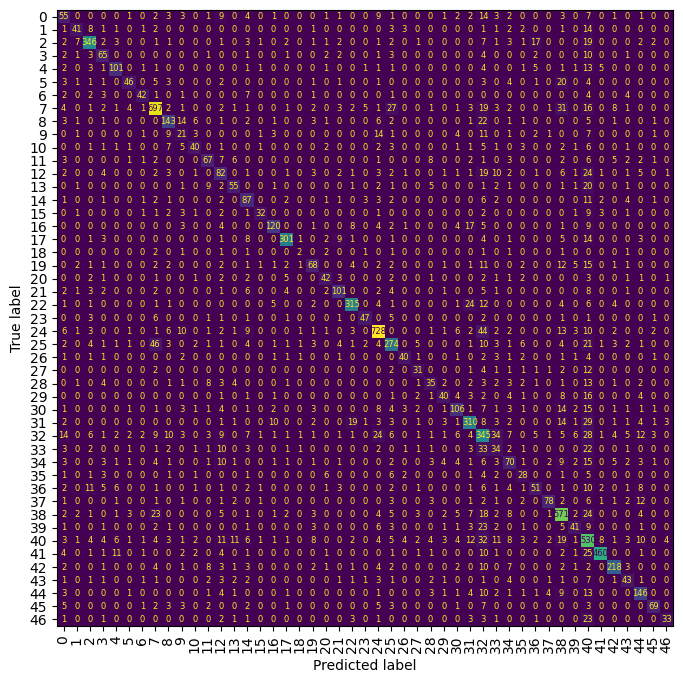

In [16]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
# Criando a exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.rcParams["figure.figsize"] = (10,8)
# Definindo o tamanho da figura
plt.figure(figsize=(10,8))
# Plotando a matriz de confusão com uma escala de cores personalizada
im = disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d', colorbar=False)
# Ajustando o tamanho da fonte manualmente
for text in im.text_.ravel():
    text.set_fontsize(6)
# Exibindo a figura
plt.show()

<Figure size 1000x800 with 0 Axes>

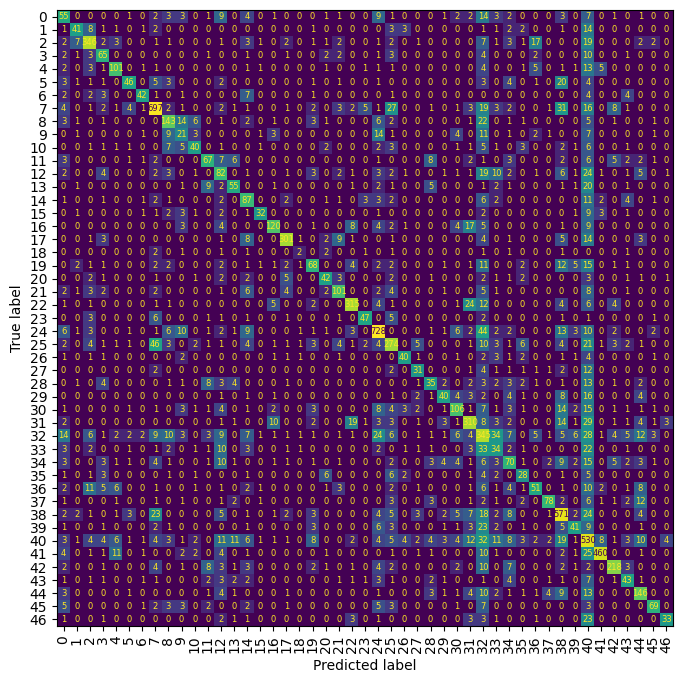

In [17]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
# Criando a exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.rcParams["figure.figsize"] = (10,8)
# Definindo o tamanho da figura
plt.figure(figsize=(10, 8))
# Obtendo a imagem da matriz de confusão com uma escala de cores personalizada
im = disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d', colorbar=False)
# Ajustando as cores para a escala logarítmica
im = plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis', norm=LogNorm())
# Adicionando a barra de cores
#plt.colorbar(im)
# Ajustando o tamanho da fonte manualmente
for text in im.axes.texts:
    text.set_fontsize(6)
# Exibindo a figura
plt.show()